In [1]:
import pandas as pd

from Models import SupportedModels
from DataLoader.SupportedData import SupportedData
from Models.ManageModels import ManageModels
from Core.Metrics import Metrics

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import subprocess
import json

import random
random.seed(42)

import numpy as np
np.random.seed(42)

# Introduction

The code was made with an interface (/Models/ModelInterface.py) that acts as base to implement ML models from different libraries such as: SciKit-Learn, PyTorch, and more...
The models currently supported by the project are listed in a Enumerator called SupportedModels

Here is the list of models that are supported:

In [2]:
supported_models_info = []

print("Models Available Are")

for i, model_type in enumerate(SupportedModels.SupportedModels):
    print(f"\t{i}) {model_type.name}")

Models Available Are
	0) GradientBoostingModel
	1) MultiLayerPerceptronModel


In addition, there is also an interface that should be implemented by a child class in order to support datasets from a different range of sources.
In this case, the project only support the Titanic Dataset.

The child class should implement the @abstract methods from the PreprocessInterface interface: 
    @RunPreprocessPipeline
    @PreprocessTrainData
    @PreprocessTestData
This allows to perform different preprocessing steps for each dataset. Because the Titanic dataset does not have the same data cleaning/preprocessing as other dataset would have...

The Scaler is also saved along the data.
    Note: By now, the Standard scaler is the only scaler that is supported.

Here is a list of all the data that is supported (again, only Titanic Dataset is supported).

In [3]:
for i, data_type in enumerate(SupportedData):
    print(f"\t{i}) {data_type.name}")

	0) TitanicData


Let's load a model that was previously trained by using the CLI.
After running the training pipeline, the CLI asks the user to save te model as .joblib format for future uses, and also saves a record in the saved_models.csv file with different attributes.

Listing the models:

In [4]:
modelsManager = ManageModels()
savedModels = modelsManager.GetSavedModels()

print(savedModels.head())

                   ModelType ModelModule     DataType         DataModule  \
0      GradientBoostingModel   Models.GB  TitanicData  DataLoader.Loader   
1      GradientBoostingModel   Models.GB  TitanicData  DataLoader.Loader   
2  MultiLayerPerceptronModel  Models.MLP  TitanicData  DataLoader.Loader   
3      GradientBoostingModel   Models.GB  TitanicData  DataLoader.Loader   

                    HourSaved  F1Score  \
0  2023-07-17 16:18:06.230180      NaN   
1  2023-07-18 11:26:17.609396      NaN   
2  2023-07-18 11:30:25.289042      NaN   
3  2023-07-18 11:37:18.685504      NaN   

                                        ModelSavedAt  \
0  ./Models/SavedModels/GradientBoostingModel-202...   
1  ./Models/SavedModels/GradientBoostingModel-202...   
2  ./Models/SavedModels/MultiLayerPerceptronModel...   
3  ./Models/SavedModels/GradientBoostingModel-202...   

                                       ScalerSavedAt  
0  ./Models/SavedScalers/StandardScaler-2023-07-1...  
1  ./Models/Saved

For this example, we are loading the model at the first record.
Which correspond to a Gradient Boosting model.

In [5]:
selectedModel = savedModels.iloc[0]

model, data_loader = modelsManager.LoadModelAndData(selectedModel)

In [6]:
selectedModel

ModelType                                    GradientBoostingModel
ModelModule                                              Models.GB
DataType                                               TitanicData
DataModule                                       DataLoader.Loader
HourSaved                               2023-07-17 16:18:06.230180
F1Score                                                        NaN
ModelSavedAt     ./Models/SavedModels/GradientBoostingModel-202...
ScalerSavedAt    ./Models/SavedScalers/StandardScaler-2023-07-1...
Name: 0, dtype: object

# Feature importance

One of the models that are supported in this project is based on Trees: SciKit-Learn's Gradient Boosting Classifier.

As this model is based on trees, it fits *number of classes* regression trees based on the gradient of the loss function.
Gradient boosting tree-based models have a feature importance attribute, because this allows them to understand which features are most important in making predictions and how much each feature contributes to the model's performance.

We can see the feature importance (in percentage), i.e. how much the attribute contributes to the model, in the following chart.


In [8]:
print(model.model.feature_importances_)
print(model.model.feature_names_in_)

[0.48193304 0.1313099  0.16806757 0.04536061 0.02836394 0.00311123
 0.12245741 0.00172738 0.01766894]
['Sex' 'Age' 'Fare' 'FamilySizeCategory' 'TicketClass_1' 'TicketClass_2'
 'TicketClass_3' 'Embarked_Q' 'Embarked_S']


<AxesSubplot: ylabel='FeatureName'>

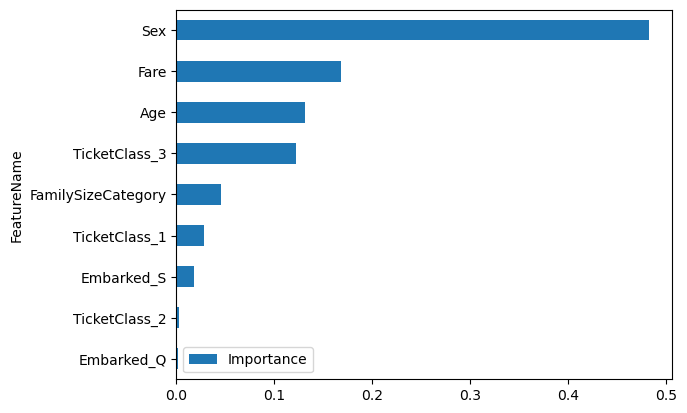

In [9]:
feature_importande_df=pd.DataFrame({'FeatureName':model.model.feature_names_in_,'Importance':model.model.feature_importances_})
feature_importande_df.sort_values('Importance',inplace=True)
feature_importande_df.plot(kind='barh',y='Importance',x='FeatureName')

As you can see, the feature that contributes the most to the classification of a sample is the Sex. This is because women are more likely to be saved than men.

According to the training set data, 74% of women were saved on the Titanic. Against only 18% of men who managed to survive.

On the other hand, the third feature with the biggest impact on predictions is age. This, together with the sex of the passenger, is perfectly in line with what we have heard for a long time **`"Women and children first"`** while evacuations are taking place.

([<matplotlib.patches.Wedge at 0x13daaa1f0>,
 [Text(0.9119041173428964, 0.6151673599704987, 'Survived'),
  Text(-0.911904146140958, -0.6151673172811853, 'Non-Survived')],
 [Text(0.497402245823398, 0.33554583271118105, '18.9%'),
  Text(-0.49740226153143163, -0.33554580942610107, '81.1%')])

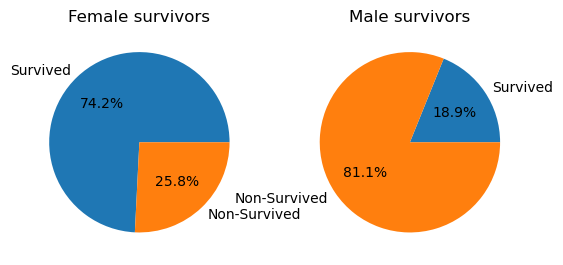

In [10]:
training_data = data_loader.Get_TrainData()

fig, (ax1, ax2) = plt.subplots(1, 2)

labels = 'Survived', 'Non-Survived'
sizes = [
    training_data.loc[(training_data['Sex']=="female") & (training_data['Survived']==1)].shape[0],
    training_data[training_data['Sex']=='female'].shape[0]-training_data.loc[(training_data['Sex']=="female") & (training_data['Survived']==1)].shape[0]
]
ax1.set_title("Female survivors")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', )


labels = 'Survived', 'Non-Survived'
sizes = [
    training_data.loc[(training_data['Sex']=="male") & (training_data['Survived']==1)].shape[0],
    training_data[training_data['Sex']=='male'].shape[0]-training_data.loc[(training_data['Sex']=="male") & (training_data['Survived']==1)].shape[0]
]
ax2.set_title("Male survivors")
ax2.pie(sizes, labels=labels, autopct='%1.1f%%')

This could be a way to automatically select features. 
Tree-based models give the most relevant attributes more power in the final class decisions, while less relevant attributes have almost no impact on the class decision.

Tree based models can select features because they belong to a type of algorithms called `embedded feature selection algorithms`. Embedded methods learn which features best contribute to the accuracy of the model while the model is being created.

Although they can select features at the time they are created, feeding these models with any feature without proper preprocessing or feature filtering can make the model unable to find all the variations in the data, leading to poor performance.

There are other models that do not perform feature selection at the time of creation. For these, we do have to analyse which features are most important.

The most popular methods of Feature Selection are:
* Pearson Correlation
* Chi-Squared
* Recursive Feature Elimination (RFE)
* Lasso


For this extra exercise, I choose the RFE search method to perform feature selection.

RFE (Recursive Feature Elimination) wrapper feature selection algorithm, which means that it uses a different machine learning algorithm at its core to assist in the feature selection process.
Wrapper feature selection techniques generate many models with various subsets of input features and choose those features which give the best performance on some performance measure.

To avoid fitting a very complex model, let's fit a simple logistic model an choose the 5 best attributes/features.
The 4 left, are going to be ranked in order of importance.

In [52]:
train_x, train_Y, test_x, test_Y = data_loader.RunPreprocessPipeline()
pred_y = model.Predict(test_x)

In [53]:
lr_model = LogisticRegression()
rfe = RFE(lr_model, n_features_to_select=5, step=1)
rfe = rfe.fit(train_x, train_Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False  True False  True False  True]
[1 1 4 2 1 3 1 5 1]


The features marked as Selected=True should be used in a model without build-in feature selection.
The other attributes (Selected=False) should be considered, according to their rank.

In [54]:
pd.DataFrame({
    "FeatureName": train_x.columns,
    "Selected": rfe.support_,
    "Ranking": rfe.ranking_
}).sort_values("Ranking")

,FeatureName,Selected,Ranking
0,Sex,True,1
1,Age,True,1
4,TicketClass_1,True,1
6,TicketClass_3,True,1
8,Embarked_S,True,1
3,FamilySizeCategory,False,2
5,TicketClass_2,False,3
2,Fare,False,4
7,Embarked_Q,False,5


RFE is a simple way to select features, however:
* It is expensive as it tries with a different combination of feature sets.
* It is recommended to use RFE along Cross Validation in order to search for the most optimal number of features (in this example, I choose 5 stochastically but, it could be the case were the most optimal number of features is 7, for instance).

# Performance

There are several metrics to analyze the performance of a machine learning classification model, the ones I included are
* F1-Score.
* ROC AUC.
* Confusion Matrix.

The results of a classification depend rely mainly on the treeshold that you choose to classify a sample into one class or another.
Generally, the treeshold is set to 0.5. Where the sample with classification rate <0.5 will be classified as 0. On the other hand, samples with rate >=0.5 will be classified are 1.

This simple threeshold can change the results in the metrics completly.
For this exercise, I left the 0.5 as default.

Talking about the metrics. Choosing the right one is dependent on the problem and where you are looking to make the least mistakes.


**For example**, in medical results (such as detecting whether a person has a disease or not) we should aim to have an excellent true-positive rate as this is the priority for detection/classification. However, we should not neglect true negatives.

For the example of medical results, we want to have a high **Recall**, as this takes into account; the correctly classified positive results in a test, and the tests where a person with a positive result was classified as negative.

------------------------

For the titanic dataset, the positive class (survived) has undersampling, so the **Accuracy** metric should not be used. Why? Accuracy is a bad metric with unbalanced datasets because, if we have for example a dataset with 10000:1 ratio of positive class samples over negative class samples, we will get a model with a high Accuracy even if we classify everything as positive class because it is the one mostly found in our data (99%).

**For this dataset, I propose to use the F1 Score because this is the harmonic mean of precision and recall, and is a good metric to use when both precision and recall are important.**

One more thing: Remember when I talked about choosing the right threeshold at the beginning of this cell?
This is because we can also use the ROC AUC score to get how good the model is based on the positive rate and false positive rate.
This metric changes depending on the threeshold we select for the classifications.

We can try threesholds of different values, such as 0.6, 0.43, 0.55, etc... And select the threeshold that best suits our rates.



In [55]:
pred_y = model.Predict(data_loader.test_x)

metrics_result = Metrics().ClassificationMetrics(data_loader.test_Y, pred_y)
for i, metric in enumerate(metrics_result):
    print(f"\n\n{metric}: \n{metrics_result[metric]}")



F1: 
0.8111888111888113


Area Under Curve: 
0.8477443609022556


Confusion Matrix: 
[[248  18]
 [ 36 116]]


Is it a good model?

There are several reasons to justify the use of this machine learning model with an F1 score of >80%:

* Balancing precision and recall: The F1 score combines both precision and recall into a single metric, giving equal weight to each. This is important in scenarios where both false positive results and false negative results can have a significant impact. The model demonstrates a good balance between correctly identifying positive examples and minimising false positives by achieving an F1 score of 80%.

* Handling unbalanced datasets: The F1 score is particularly useful when dealing with unbalanced datasets, where one class may have significantly more samples than the other. Accuracy alone may not provide an accurate assessment of model performance in such cases. The F1-Score takes into account the performance of the model on both classes, providing a more comprehensive evaluation.

* Class-wise performance: The F1 score assesses the predictive ability of the model by looking at its performance on a class-by-class basis. This means that rather than giving an overall performance, it assesses the performance of the model on each class separately. This can be useful when looking to see how the model performs on different classes. **An F1 score of 80% is an indication that the model has good performance and a high level of accuracy. While there may be room for improvement.**



__Overall, especially when considering the specific context, dataset and requirements of the problem at hand, a machine learning model with an F1 score of 80% can be considered reliable and effective.__

Here is an example of Prediction.
Let's take the Person in the testing dataset at index `51` and send this information as model's data in order to perform a prediction.

In [70]:
titanic_sample = test_x.iloc[[51]]
titanic_sample

print(f"Passenger information {titanic_sample}")

test_Y.index[titanic_sample.index]
print("\n\nPredicted value: ",model.Predict(test_x.sample())[0])
print("True: ",int(test_Y[titanic_sample.index]))

Passenger information     Sex       Age      Fare  FamilySizeCategory  TicketClass_1  TicketClass_2  \
51    0 -0.181487 -0.345731                   0              0              1   

    TicketClass_3  Embarked_Q  Embarked_S  
51              0           0           0  


Predicted value:  0
True:  0


# Deployment

How can we put into production a model that we are satisfied with according to the metrics?
Since we are storing the weights of the models in a folder, we can read them directly from the directory where they are located and put them into production.
The most common way to do this is to expose them through an API.

In Python there are several libraries that allow us to create a web server with very few lines of code. One of them is FastAPI. Combining FastAPI with Docker offers us a very powerful way of containerization that will help us to lift an API from our model and it can start being consumed in a matter of minutes.

My approach to send a model to Production would be the following:

1. Build a FastAPI based project with POST requests so that the model can make inferences.
2. The FastAPI code should read the selected model from the specified directory, and then load it.
3. Generate a Dockerfile (that you can find in the root directory of this project) containing different steps such as:
    * Using a Python based base image.
    * Install the project requirements.
    * Copy the FastAPI-based project files to the directory, for example, /app of the container.
    * install the requirements from the requirements.txt file
    * Expose the container port
    * Run the FastAPI project
4. Use a Virtual Machine from an On-Premise or a Cloud environment to host our code.

`*This is a general pipeline*. Other aspects should also be covered like`:
* Store Logging information.
* Monitor the performance of the model over time.
* Scaling to support of houndreds of users.
* Addind security measures.
* And more...

## Cloud Architecture
For deploying this machine learning model, I would suggest to select an architecture based on the following question: "Do we need to inference data in real time?"
If the answer is Yes, then we should consider use a real-time (or "online) archirecture: This type of architecture allow use to receive a query and return an inference as it is received with a very low latency between client and server. However, this is a very expensive to implement.
If the answer it No, we can use a batch processing architecture where the model processed a batch of data instead of just a single record to then make an inference on that batch of data. This architecture should be used when the reponse time is not important and working with a large volume of data.

I also suggets to use a more automated pipeline for deployment, by using AWS:
* Data storage: Store the training and testing data in a Amazon S3 Bucket.
* Data preprocessing: Create an AWS Lambda for pre-processing our dataset. Lambda is recommended over a continuously running python script because the preprocessing step for training a model runs just once.
* Model training: Use Amazon SageMaker to create, train and deploy the model into production.
    * Store model weights back to the S3 Bucket.
* Model evaluation: Use Amazon SageMaker as well.

* Note; Alternatively, we can train the model using a EC3 instance and expose a web server.

Amazon Web Services also helps with load balacing and by using a Kubernetes serice to manage all the containers.

# Coverage Report

We can run a Coverage report, which indicates the effectiveness of the unit test written.
This coverage report indicates which parts of the code are executed by the testing and with others are not.

The following cells ejecute the Coverage report generation which you can see in a DataFrame format.

In [2]:
subprocess.run(["coverage", "json", "-o" ,"./Tests/Output/Json/coverage.json"])

coverage_report = None

with open('./Tests/Output/Json/coverage.json') as f:
    coverage_report = json.load(f)

Wrote JSON report to ./Tests/Output/Json/coverage.json


In [72]:
coverage_report
coverage_data = []
for file in coverage_report['files']:
    coverage_data.append({
        "Module": file,
        "Statements": coverage_report['files'][file]['summary']['num_statements'] ,
        "Covered Lines":coverage_report['files'][file]['summary']['covered_lines'] ,
        "Missing":coverage_report['files'][file]['summary']['missing_lines'] ,
        "Coverage":int(coverage_report['files'][file]['summary']['percent_covered_display']) ,
        "Excluded":coverage_report['files'][file]['summary']['excluded_lines'] ,
    })

print(f"Overval Coverage: {coverage_report['totals']['percent_covered_display']}")
pd.DataFrame(coverage_data).sort_values(by=['Coverage'], ascending=False)

Overval Coverage: 62


,Module,Statements,Covered Lines,Missing,Coverage,Excluded
9,Models/__init__.py,0,0,0,100,0
5,DataLoader/__init__.py,0,0,0,100,0
17,Utils/__init__.py,0,0,0,100,0
16,Utils/Settings.py,6,6,0,100,0
10,Tests/__init__.py,0,0,0,100,0
18,__init__.py,0,0,0,100,0
4,DataLoader/SupportedScalers.py,5,5,0,100,0
2,Core/__init__.py,0,0,0,100,0
3,DataLoader/Loader.py,56,54,2,96,0
0,Core/Metrics.py,17,14,3,82,0


The table presents all the files that are part of the project and how the unit test process covered them.

The table is comprised of the following columns:

* Module: Name of the file.
* Statements: Number of executable statements in a Python program
* Covered Lines: Number of lines that were executed out of the total lines part of the coverage.
* Missing: How many lines were not executed from the total statements in the coverage run.
* Coverage: Coverage of lines executed in percentage.
* Excluded: Lines not part of the Coverage execution.

--------------------

With coverage reports, we aim to get close to 100% coverage, because that way we can be sure that most of our code is properly tested before it goes into production.

However, there is some debate in the community about achieving such a percentage because it can be time-consuming, expensive, and otherwise inconvenient.

While code coverage is important to ensure the effectiveness of unit tests, it is not always necessary or practical to aim for 100% coverage. Focusing on writing high-quality tests that cover critical functionality, and prioritizing testing efforts based on the specific needs of the project, is more important.

We can also run the pytest and see how many of our unit tests are passed or failed.

In [3]:
subprocess.run(["python", "-m", "pytest"])

============================= test session starts ==============================
platform darwin -- Python 3.9.12, pytest-7.4.0, pluggy-1.2.0
rootdir: /Users/carloflo/Documents/Me/Rp
collected 10 items

Tests/test_interfaces.py ..                                              [ 20%]
Tests/test_loader.py ..                                                  [ 40%]
Tests/test_metrics.py ....                                               [ 80%]
Tests/test_modelsmanager.py ..                                           [100%]

============================== 10 passed in 1.88s ==============================


CompletedProcess(args=['python', '-m', 'pytest'], returncode=0)

The next cell opens the browser and allows us to see in a more visual way which lines were not executed in our Coverage test, and to be able to cover with unit tests the parts that we believe are more critical to test.

In [73]:
subprocess.run(["coverage", "html", "-d" ,"./Tests/Output/Html/"])
subprocess.run(["open", "./Tests/Output/Html/index.html"])

Wrote HTML report to ./Tests/Output/Html/index.html


CompletedProcess(args=['open', './Tests/Output/Html/index.html'], returncode=0)